In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [29]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
gE = 0.1
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([50, 50])
Ia0 = np.array([50, 50])  # each age group has asymptomatic infectives
Is0 = np.array([50, 50])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 200
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}

# use pyross stochastic to generate traj and save 

sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data=sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

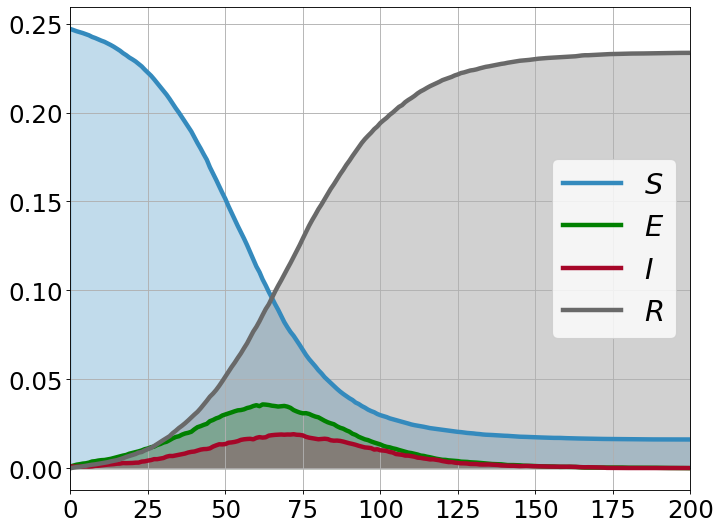

In [30]:
# plot the data and obtain the epidemic curve for one age group 

S  = data['X'][:,0]
E  = data['X'][:,2]
Ia = data['X'][:,4]
Is = data['X'][:,6]
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)


plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

# Infer parameters based on part of the trajectory

In [31]:
# load the data and rescale to intensive variables 
Tf_inference = 50 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('sto_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101


fltr=np.repeat(np.array([False, False, False, True]), M)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]



estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)


# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-729.4277283901382
0.7081620693206787


In [32]:
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm, can use as a lower bound for parameters 

alpha_g = 0.2
alpha_bounds = (0.1, 0.5) # large uncertainty on the fraction of asymptomatic people 
# the upper bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.07
beta_bounds = (eps, 0.1) # large uncertainty on beta (e.g. during a lockdown, beta can be very low)

gIa_g = 0.2
gIa_bounds = (eps, 0.5) # large uncertainty on how quickly asymptomatic people recover 

gIs_g = 0.145
gIs_bounds = (0.13, 0.15) # tight bounds on gIs (can come from clinical data)

gE_g = 0.22
gE_bounds = (0.15, 0.25) # tight bounds on the exit rate from the exposed class 

fsa_g = 0.8 # assume we know this precisely 


# guesses for the unknown initial conditions 
E0_g = (E0+5)/N 
bounds_for_E = [(0.1/N, 100/N)]*M #large uncertainty 
Ia0_g = (Ia0+5)/N
bounds_for_Ia = [(0.1/N, 100/N)]*M #large uncertainty 
S0_g = (S0-10)/N
bounds_for_S = [(fi[i]-200/N-Is0[i]/N, fi[i]-0.1/N) for i in range(M)]

# as a result of the van kampen system size expansion, Is0 does not have to be the same as the true value 
Is0_g = Is0/N 
bounds_for_Is = [(5/N, 14/N)]*M 

# optimisation parameters 
ftol = 1e-3 # the relative tol in (-logp)  

# set up bounds 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, 
                    *bounds_for_S, *bounds_for_Is, *bounds_for_Ia, *bounds_for_Is])

In [33]:
start_time = time.time() 
# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, *S0_g, *E0_g, *Ia0_g, *Is0])
params = estimator.latent_inference(guess, obs, fltr, Tf_inference, Nf_inference, contactMatrix, 
                                    bounds, verbose=True, niter=4, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here end_time = time.time()
print(params) # best guess 
print(end_time - start_time)

parameters: [0.39916161 0.02359535 0.39916161 0.14831936 0.17352896]
parameters: [0.40036676 0.02270642 0.40030847 0.14874777 0.1733161 ]
parameters: [0.39566651 0.02374536 0.39559995 0.14872997 0.17442627]
parameters: [0.39024467 0.02413567 0.39021747 0.14894078 0.17586959]
parameters: [0.38133203 0.02373164 0.38143698 0.14961263 0.17846474]
parameters: [0.38350121 0.02293806 0.38364131 0.14973749 0.17804604]
parameters: [0.38348948 0.02249247 0.38368935 0.14992008 0.178216  ]
parameters: [0.38107124 0.02187483 0.38143227 0.15       0.17923639]
parameters: [0.36985677 0.02054216 0.37076637 0.15       0.18340677]
parameters: [0.36764349 0.0209125  0.36858423 0.14995719 0.18401137]
parameters: [0.35836513 0.0214139  0.35957291 0.149881   0.18692657]
parameters: [0.34783384 0.02140813 0.34942473 0.14986283 0.19045536]
parameters: [0.31692776 0.02077769 0.3197295  0.14988063 0.20104449]
parameters: [0.22764025 0.01808275 0.23406152 0.15       0.23195492]
parameters: [0.21803584 0.01672962

In [34]:
np.save('latent_SEIR_params.npy', params)

In [35]:
params = np.load('latent_SEIR_params.npy')
print('best estimates for params: ', params[:5])
print('best estimates for initial conditions: ', params[5:])

best estimates for params:  [0.1        0.01756585 0.49956599 0.15       0.25      ]
best estimates for initial conditions:  [2.45e-01 7.45e-01 2.80e-04 2.80e-04 2.00e-03 2.00e-03 2.80e-04 2.80e-04]


In [36]:
hess_params, hess_init = estimator.hessian_latent(params, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)

In [37]:
cov_params = np.linalg.inv(hess_params)
cov_init = np.linalg.inv(hess_init)

# Compare forecast based on inferred parameters to full trajectory

In [38]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],
              'gE':params[4],
            'S0':params[5: 5+M],
            'E0':params[5+M:5+2*M],
            'Ia0':params[5+2*M:5+3*M],
              'Is0':params[5+3*M:],
              'fsa':fsa,
             'cov_init':cov_init, 'cov_params':cov_params}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEIR_latent(parameters, M, Ni)

[0.245 0.745]
[0.00028 0.00028]


In [39]:
# Number of simulations over which we average
Ns = 500 

Tf_forecast = Tf
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t']

Finished. Time needed for evaluation: 00:00:09


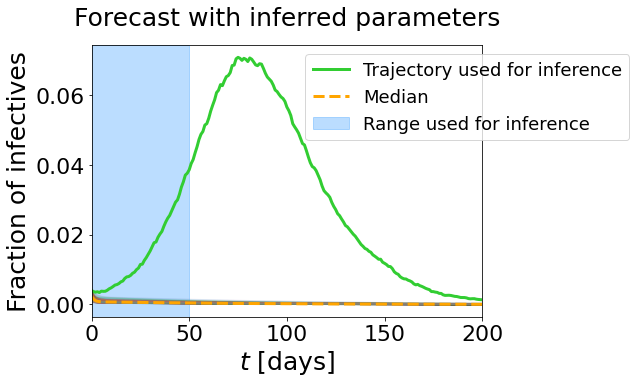

In [40]:
fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = np.sum( data_array[:,2*M:] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=18)
plt.show(fig)
plt.close(fig)